## 4. Modelling GW well data using a Random Forest

In [1]:
## First, lets import all neeeded libraries

import os, sys
# import netCDF4
import pandas as pd
#import datetime
#from datetime import date, datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import geopandas as gpd
import rioxarray
import xarray as xr
import glob

import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

In [2]:
from io import StringIO
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import math
from math import sqrt

In [3]:
pwd = os.getcwd()
print(pwd)

/Users/marie-christineckert/Nextcloud/TU/Lehre/AktuelleAnwendungen_SoSe24/7_GW_Model_Example


### 4.1. Read data from previous script

Quick reminder on what we did in the previous script. We clipped the .nc file to AOI and stacked .nc files for specific years into one. We then extracted climate data at a specific locations, merged them with GW level data and saved the data for each well location as one singular csv file. These files are now the bassis for our model building.

Our next step is model buidling. We will first do it for one singular csv file exemplary, prior to feeding all data into one model:

In [4]:
data = pd.read_csv("./data/HYRAS_GWData_csv/BB_27381010_weeklyData_HYRAS_GWData.csv", skipinitialspace=True).drop(['Unnamed: 0'], axis=1)

data.shape[0]

835

In [5]:
col2use = ['pr', 'tas', 'GWL']

In [6]:
#data = data.replace(np.inf, np.nan)
data.isnull().sum()

Date      0
pr        0
tas       0
GWL     380
dtype: int64

In [7]:
## although there are wuite a few NA values
## for the sake of simplicity we will drop NA values for now:

data.dropna(axis=0, inplace=True)
data

## later we might want to use imputation methods, or play around with the TS length in the preprocessing part

,Date,pr,tas,GWL
380,1997-04-14,1.400000,4.600000,48.520
381,1997-04-21,0.100000,7.671429,48.535
382,1997-04-28,16.400000,11.157143,48.550
383,1997-05-05,30.900000,9.885714,48.590
384,1997-05-12,11.400001,15.942857,48.550
...,...,...,...,...
830,2005-11-28,6.000000,0.357143,48.290
831,2005-12-05,3.100000,2.942857,48.290
832,2005-12-12,30.500000,3.200000,48.280
833,2005-12-19,14.700000,3.485714,48.270


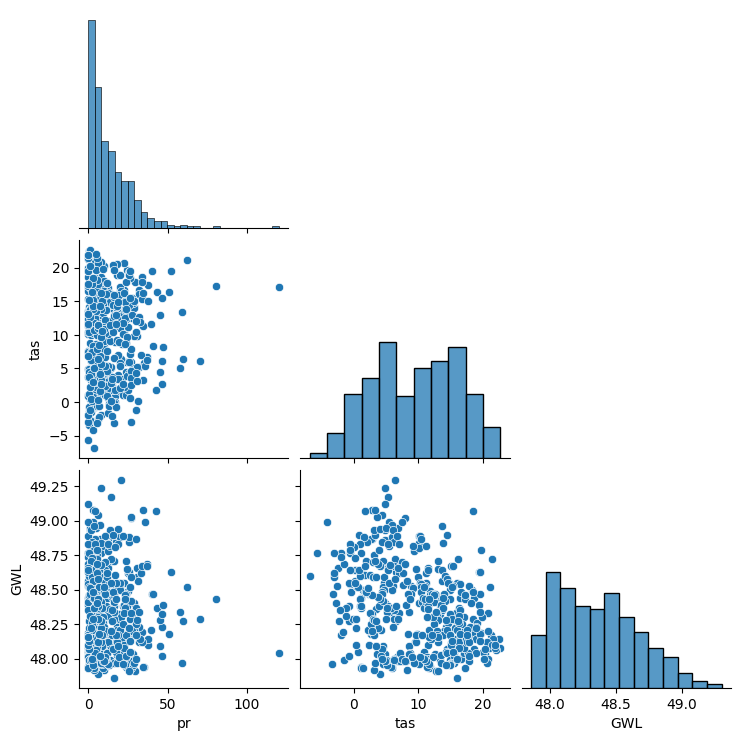

In [8]:
sns.pairplot(data[col2use], corner=True)
plt.show()

Ok we already know what to do here: When our distributions are this skewed, we might want to apply **feature scaling**!

As we have seen in previous scripts, random forests are not as sensitive to unscaled features. For sake of simplicity, we might want to skip this part here. 

Remember that it can significantly change our model accuracy and thus should be consired, also when constructing a RF model!

In the next modeling approach, we will build a KNN. Feature scaling will be necessary! This is why we keep that part for the next script. 

### 4.2. Initial Radom ForestModel


We will now read all csv files into one pd.DataFrame, by appending the rows. We can ignore the date column, as it does not add valueable information to our RF model. Training a single model requires leveraging all the data, therefore we need to:

  **1.** Load each CSV file individually and treat each one as a separate sample.
  
  **2.** Prepare the data for training (feature engineering and target variable) for each sample --> feature scaling
  
  **3.** Combine the processed data into a single DataFrame for model training.
  
  **4.** Split the combined data into training and testing sets.
  
  **5.** Train the Random Forest Regressor on the combined dataset.
  
  **6.** Evaluate the model.

#### Step 1 -3: Looping through all files and combine into single DataFrame

In [9]:
pwd = os.getcwd()
print(pwd)

/Users/marie-christineckert/Nextcloud/TU/Lehre/AktuelleAnwendungen_SoSe24/7_GW_Model_Example


In [10]:
# Load multiple CSV files
csv_files = glob.glob('data/HYRAS_GWData_csv/*.csv')  # Adjust the pattern as needed

In [11]:
# Prepare a list to hold the processed DataFrames
processed_samples = pd.DataFrame()

for file in csv_files:
    df = pd.read_csv(file, skipinitialspace=True).drop(['Unnamed: 0'], axis=1)
    
    # Combine all processed samples into a single DataFrame
    processed_samples = pd.concat([processed_samples,df], axis=0)



As a next step, we check the data for missing values.

In [12]:
processed_samples.isnull().sum()

Date      0
pr        0
tas       0
GWL     380
dtype: int64

... and drop the missings, since GWL is the target feature.

In [13]:
processed_samples.dropna(axis=0, inplace=True)
processed_samples

,Date,pr,tas,GWL
0,1990-01-01,1.0,-0.728571,39.75
1,1990-01-08,3.3,3.871429,39.79
2,1990-01-15,12.6,6.185714,39.82
3,1990-01-22,26.4,5.742858,39.85
4,1990-01-29,4.9,6.057143,39.90
...,...,...,...,...
830,2005-11-28,6.0,0.357143,8.99
831,2005-12-05,3.1,2.942857,8.98
832,2005-12-12,30.5,3.200000,8.95
833,2005-12-19,14.7,3.485714,8.98


#### Step 4: Split into Training and Test Data

In [14]:
processed_samples = processed_samples.set_index(pd.DatetimeIndex(processed_samples['Date']))
del processed_samples['Date']

In [15]:
processed_samples

,pr,tas,GWL
Date,,,
1990-01-01,1.0,-0.728571,39.75
1990-01-08,3.3,3.871429,39.79
1990-01-15,12.6,6.185714,39.82
1990-01-22,26.4,5.742858,39.85
1990-01-29,4.9,6.057143,39.90
...,...,...,...
2005-11-28,6.0,0.357143,8.99
2005-12-05,3.1,2.942857,8.98
2005-12-12,30.5,3.200000,8.95


In [17]:
# Separate features and target
X = processed_samples.drop(columns=['GWL'])
y = processed_samples['GWL']

In [18]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Step 5: Train initial Model

In [19]:
# Initialwert und Anzahl der Bäume für den Random Forest festlegen
seed = 196
n_estimators = 100

# RandomForest erstellen, X und y definieren und Modell trainieren
model = RandomForestRegressor(n_estimators = n_estimators, random_state = seed, max_features = 1.0,
                               min_samples_split = 2, min_samples_leaf = 1, max_depth = None)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=196)

#### Step 5: Evaluate!

In [20]:
# Mittelwert der quadrierten Residuen und erklärte Varianz ausgeben lassen
print(f"Mean of squared residuals: {model.score(X_train, y_train)}")
print(f"% Var explained: {model.score(X_train, y_train) * 100}")


Mean of squared residuals: 0.01330598616545886
% Var explained: 1.330598616545886


So what does this figure tell us? The RMSE is the root of the mean of the squared deviations between the prediction and the "truth". So a value of 0.015, or 0.055m in units, is a very good value. So we could conclude that our model is very good.

However, we might be lucky in our choice of training and test data. To reduce the influence of this split, we perform a so-called k-fold cross validation. This means that we take the training data and split it into 10 equal pieces, i.e. $k=10$ here. We then train the model on nine of the 10 pieces and use the 10th piece to validate the model as above. This process is repeated 10 times, each time using a different piece for validation. In the end we get 10 RMSE values which give us some insight into the validity of the above value.

In [22]:
from sklearn.model_selection import cross_val_score
scores = - cross_val_score(estimator=model, X=X_train, y=y_train, cv=10, scoring='neg_mean_squared_error', n_jobs=1)
print(scores)
print(np.mean(scores), np.std(scores))

[425.85558308 478.5421104  492.85522439 435.77191885 448.74898096
 462.5313293  488.54752814 472.46033335 484.05753463 451.08150092]
464.04520440080876 21.84948257888147


### 4.3. Hyperparameter Tuning

In our session a few weeks ago, we learned about RF Hyperparameter Tuning. First, we wil evaluate how many trees to use (750 seems about fine). Apply your knowledge about the other hyperparameters here and improve the random forests performance by tuning the hyperparameters on your own. 

> **Note:** We only have 2 input features. You might want to skip all hyperparamters that deal with the number of feautres used in the RF, such as `max_features`!



### gridSearchCV

In [26]:
from sklearn.model_selection import GridSearchCV

In [27]:
rfc = RandomForestRegressor(random_state=42)


In [31]:
param_grid = { 
    'n_estimators': [100,200,300, 400, 500, 600, 700, 800, 900, 1000],
   # 'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
#    'criterion' :['gini', 'entropy']
}

In [32]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [4, 5, 6, 7, 8],
                         'n_estimators': [100, 200, 300, 400, 500, 600, 700,
                                          800, 900, 1000]})

In [36]:
best_params = CV_rfc.best_params_

best_params

{'max_depth': 4, 'n_estimators': 100}

In [37]:
# Initialwert und Anzahl der Bäume für den Random Forest festlegen
seed = 196


# RandomForest erstellen, X und y definieren und Modell trainieren
model = RandomForestRegressor(n_estimators = best_params["n_estimators"], 
                              random_state = seed, 
                              max_features = 1.0,
                              min_samples_split = 2, 
                              min_samples_leaf = 1, 
                              max_depth = best_params["max_depth"])
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, random_state=196)

In [38]:
X_train

,pr,tas
Date,,
1999-02-08,2.700000,-4.157143
2004-06-14,27.500000,12.971429
1999-11-01,4.600000,8.585714
1993-08-02,18.900000,16.585714
1999-10-04,11.800000,10.871429
...,...,...
2000-10-02,13.000000,11.385714
1998-05-25,9.000000,14.800001
2004-07-26,6.100000,17.557142


### Lets plot

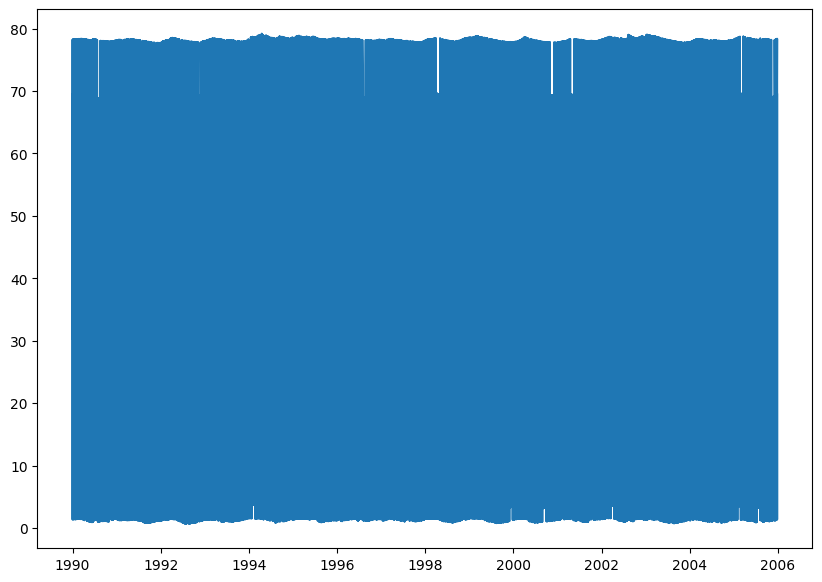

In [46]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,7))

plt.plot(y_train.sort_index())
#plt.plot(y_val.index, y_val_pred)
plt.show()